In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.datasets import make_classification
from sklearn.tree import export_graphviz
import graphviz
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

In [ ]:
df_dk=pd.read_csv('/content/Keylogger_Detection.csv')

<ipython-input-6-25830dcd86de>:1: DtypeWarning: Columns (48,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dk=pd.read_csv('/content/drive/MyDrive/Keylogger/Keylogger_Detection.csv')


In [ ]:
df_dk.shape

(523617, 86)

In [ ]:
Class_df = df_dk["Class"]
df_num = df_dk.select_dtypes(include=[np.number])
df_num = df_num.join(Class_df)

# ***Data Preprocessing***

In [ ]:
df_num.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df_num["label"]=df_num["Class"]
df_num.loc[df_num.label == "Benign", 'label'] = 0
df_num.loc[df_num.label == "Keylogger", 'label'] = 1
df_num.drop('Class', axis=1, inplace=True)
df_num.sample(5)

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
393185,16532.0,53.0,17.0,462610.0,1.0,1.0,38.0,81.0,38.0,38.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
482175,38215.0,53.0,17.0,888490.0,1.0,1.0,45.0,108.0,45.0,45.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
294201,443.0,39026.0,6.0,28.0,2.0,0.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
98626,41398.0,443.0,6.0,121.0,2.0,0.0,0.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
426378,47670.0,443.0,6.0,10456976.0,4.0,2.0,0.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


***Replacing NULL values with mean***

In [ ]:
# df_num.fillna(df_num.mean(), inplace=True)
for i in df_num.iloc[:,:-1].columns:
  m = df_num[i].mean()
  df_num[i].fillna(value=m, inplace=True)
df_num['label'].fillna(df_num['label'].mode()[0], inplace=True)

***Removing columns with constant value***

In [ ]:
for col in (df_num.iloc[:,:-1].columns):
    if(df_num[col].min()==df_num[col].max()):
            df_num.drop(col, axis=1, inplace=True)

***EDA Functions***

head() and tail(): These functions are used to display the first few rows and last few rows of the dataset, respectively. They are useful for quickly getting a sense of what the data looks like.

shape: This function is used to determine the number of rows and columns in the dataset.

describe(): This function provides a summary of the statistical properties of each numerical column in the dataset, such as the mean, standard deviation, and quartiles.

info(): This function provides information about the data types and missing values in each column of the dataset.

value_counts(): This function is used to count the number of occurrences of each value in a categorical column of the dataset.



In [ ]:
df_num.describe()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,label
count,523617.000000,523617.000000,523617.000000,5.236170e+05,523617.000000,523617.000000,5.236170e+05,5.236170e+05,523617.000000,523617.00000,...,5.236170e+05,5.236170e+05,5.236170e+05,5.236170e+05,5.236170e+05,5.236170e+05,5.236170e+05,5.236170e+05,5.236170e+05,523617.000000
mean,38389.622917,6222.747054,8.435195,1.116307e+07,9.475619,17.819533,1.043487e+03,2.156387e+04,215.842782,11.25795,...,-2.135277e+04,1.659947e+05,2.369898e+04,1.887055e+05,1.482351e+05,4.390550e+06,4.059862e+05,4.738970e+06,4.082014e+06,0.410231
std,18713.642457,15681.211329,157.569965,2.307145e+07,97.897284,321.858169,5.361425e+04,4.633844e+05,369.316080,53.05277,...,5.168982e+06,9.027333e+05,3.757752e+05,1.078265e+06,8.526251e+05,1.511080e+07,3.337638e+06,1.598375e+07,1.470320e+07,0.491876
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.00000,...,-1.395062e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,34019.000000,80.000000,6.000000,3.730600e+04,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.00000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,43186.000000,443.000000,6.000000,4.745050e+05,2.000000,1.000000,3.100000e+01,0.000000e+00,31.000000,0.00000,...,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
75%,52281.000000,443.000000,6.000000,1.031474e+07,6.000000,4.000000,4.620000e+02,4.140000e+02,350.000000,0.00000,...,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
max,124560.000000,65428.000000,65812.000000,1.199967e+08,8671.000000,14993.000000,1.249095e+07,2.166097e+07,1460.000000,1460.00000,...,1.705248e+08,5.041965e+07,5.795123e+07,9.139736e+07,4.993167e+07,1.196749e+08,7.554958e+07,1.196749e+08,1.196749e+08,1.000000


***correlation matrix***

The correlation coefficient measures the relationship between two variables, ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation), with 0 indicating no correlation.

In a correlation matrix, values are symmetric, meaning the correlation between A and B is the same as between B and A. The diagonal always has a correlation of 1 for each variable with itself.






In [ ]:
# Calculate the correlation matrix
corr_matrix = df_num.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop the highly correlated columns
df_num = df_num.drop(to_drop, axis=1)

<ipython-input-14-61204f0991d5>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


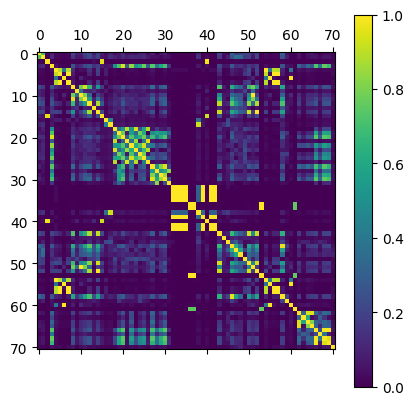

In [ ]:
plt.matshow(corr_matrix)
# plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=100)
# plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.colorbar()
plt.show()


***Standarization using z-score***

Standardizing using z-score involves transforming a dataset so that it has a mean of 0 and a standard deviation of 1.

In [ ]:
df1 = df_num.copy()

In [ ]:
m = 0
s = 0
for i in df_num.iloc[:,:-1].columns:
  m = df_num[i].mean()
  s = df_num[i].std()
  df_num[i] = abs(df_num[i] - m) / s
# z = (x-m)/s

In [ ]:
# def standardize(df,col):
#     #df[col]= (df[col]-df[col].mean())/(df[col].std()) # Standardization
#     df[col]= 255*(df[col]-df[col].min())/(df[col].max()-df[col].min()) #Normalization

# for i in (df_num.iloc[:,:-1].columns):
#     standardize (df_num,i)

# df_num.head()

In [ ]:
df_num.shape

(523617, 39)

In [ ]:
target=['label']
features = [c for c in df_num.columns if c!="label"]

In [ ]:
X = df_num[features].values # Features
y = df_num[target].values # Target

X=X.astype(np.float32)
y=y.astype(np.float32)

X.shape,y.shape,

((523617, 38), (523617, 1))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((418893, 38), (104724, 38), (418893, 1), (104724, 1))

In [ ]:
Models= ["knn", "decision tree", "random forest"]
Accuracy = []
Recall = []

# ***knn***

K-Nearest Neighbors (KNN) finds the k-nearest data points from the training dataset to a test instance. It uses a similarity metric, like Euclidean distance or cosine similarity, to determine proximity. The predicted class label for the test instance is based on the majority class label among its k-nearest neighbors. For instance, if k=3 and two neighbors belong to class A while one belongs to class B, the predicted class label would be A.

 ***optimal K Value***

In [ ]:
# best_k = None
# best_accuracy = 0
# for k in range(1, 15):
#     # Train the KNN model
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn.fit(X_train, y_train)

#     # Validate the model
#     y_pred = knn.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred.round(), normalize=False)

#     # Choose the best k value
#     if accuracy > best_accuracy:
#         best_k = k
#         best_accuracy = accuracy

In [ ]:
# print(best_k)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# Predict on the testing set
y_pred = knn.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
recall = recall_score(y_test, y_pred)
Accuracy.append(accuracy)
Recall.append(recall)

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.9710095107138764


***confusion matrix for knn***

A confusion matrix is a table used to evaluate the performance of a classification model by comparing the predicted class labels with the true class labels of a set of test data. The confusion matrix provides a summary of the number of correct and incorrect predictions for each class.

A typical confusion matrix has four entries, corresponding to four possible outcomes:

True Positive (TP): the number of instances that are actually positive (belonging to the positive class) and are correctly predicted as positive by the model.

False Positive (FP): the number of instances that are actually negative (belonging to the negative class) but are incorrectly predicted as positive by the model.

True Negative (TN): the number of instances that are actually negative and are correctly predicted as negative by the model.

False Negative (FN): the number of instances that are actually positive but are incorrectly predicted as negative by the model.

accuracy is the proportion of correct predictions out of the total number of predictions
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)



<Axes: >

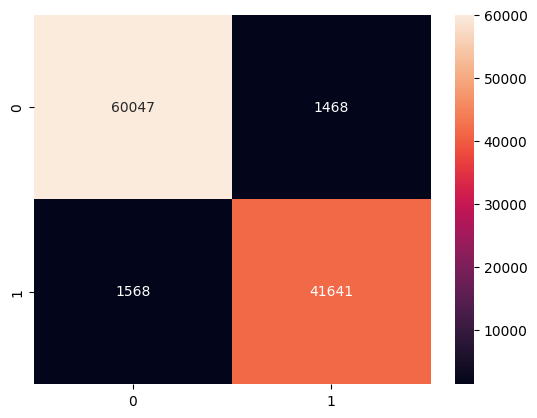

In [ ]:
cm = confusion_matrix(y_test,y_pred)
#Plot the confusion matrix.
sns.heatmap(cm,annot=True,fmt='g')

 ***ROC graph for KNN***

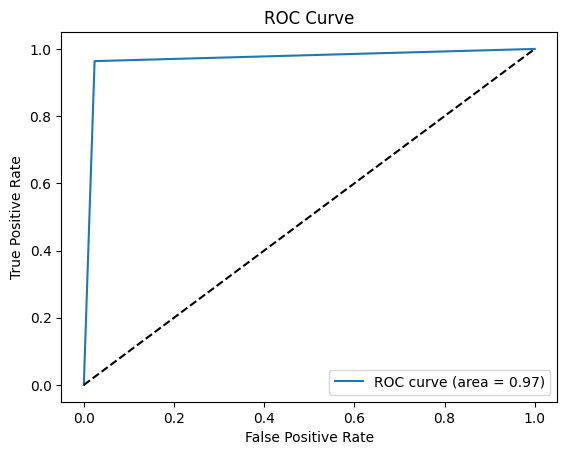

In [ ]:
# Compute the predicted probabilities for the test set
y_pred_prob = knn.predict_proba(X_test)[:, 1]

# Compute the false positive rate (FPR), true positive rate (TPR), and the corresponding thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line representing a random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# ***Decision_tree***

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Make predictions on the testing data and calculate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
recall = recall_score(y_test, y_pred)
Accuracy.append(accuracy)
Recall.append(recall)

Accuracy: 0.9735877162828005


***confusion matrix for decision tree***

<Axes: >

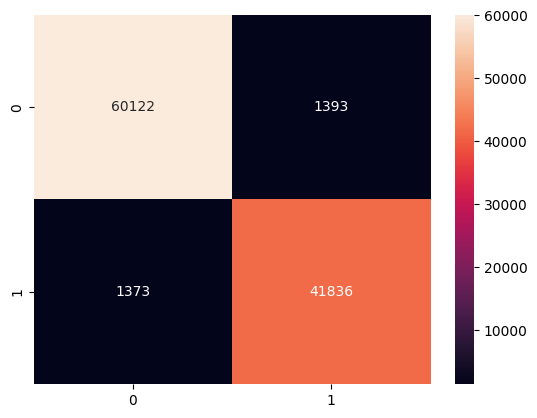

In [ ]:
cm = confusion_matrix(y_test,y_pred)
#Plot the confusion matrix.
sns.heatmap(cm,annot=True,fmt='g')

***ROC graph for decision tree***

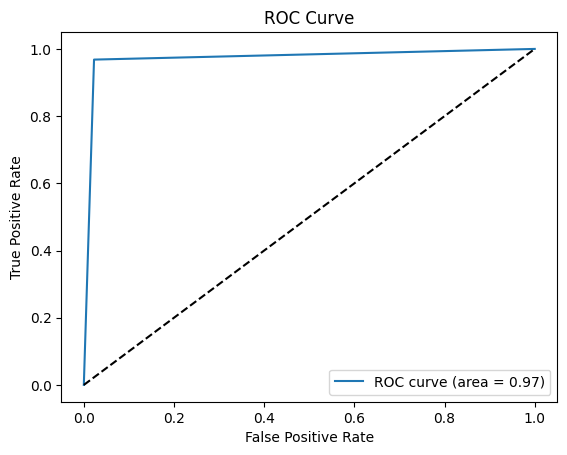

In [ ]:
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Compute the false positive rate (FPR), true positive rate (TPR), and the corresponding thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line representing a random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# ***Random_Forest***

In [ ]:
rfc = RandomForestClassifier()

# Train the model
rfc.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rfc.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
Accuracy.append(accuracy)
Recall.append(recall)

<ipython-input-33-454ef9b79156>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Accuracy: 0.9739505748443528
Precision: 0.9749618678868943
Recall: 0.9615589344812423
F1 Score: 0.968214019388516


***confusion matrix for Random_Forest***

<Axes: >

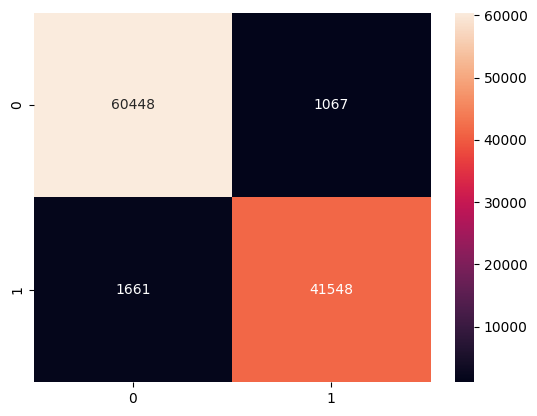

In [ ]:
cm = confusion_matrix(y_test,y_pred)
#Plot the confusion matrix.
sns.heatmap(cm,annot=True,fmt='g')

***confusion matrix for random_forest***

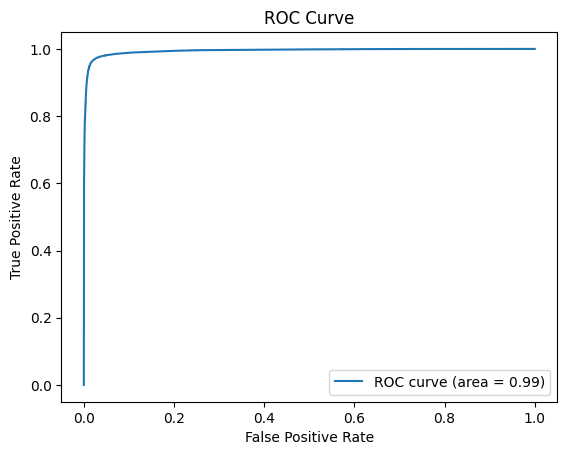

In [ ]:
y_pred_prob = rfc.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
#eplt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line representing a random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
X, y = make_classification(n_samples=20000, n_features=10, n_classes=2, random_state=42)

# train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

# export the decision tree as a dot file
dot_data = export_graphviz(clf, out_file=None, feature_names=['X'+str(i) for i in range(1, 11)],
                           class_names=['No Keylogger', 'Keylogger'], filled=True, rounded=True)

# create graph from dot file and display it
graph = graphviz.Source(dot_data)
graph.render("keylogger_detection")
graph.view()

'keylogger_detection.pdf'

Tuning hyperparameters
Using ensemble methods
confusion matrix
corelation(low corelated) ----
EDA FUNCTONs
knn, random forest paramter values
parameters tuning

<Axes: >

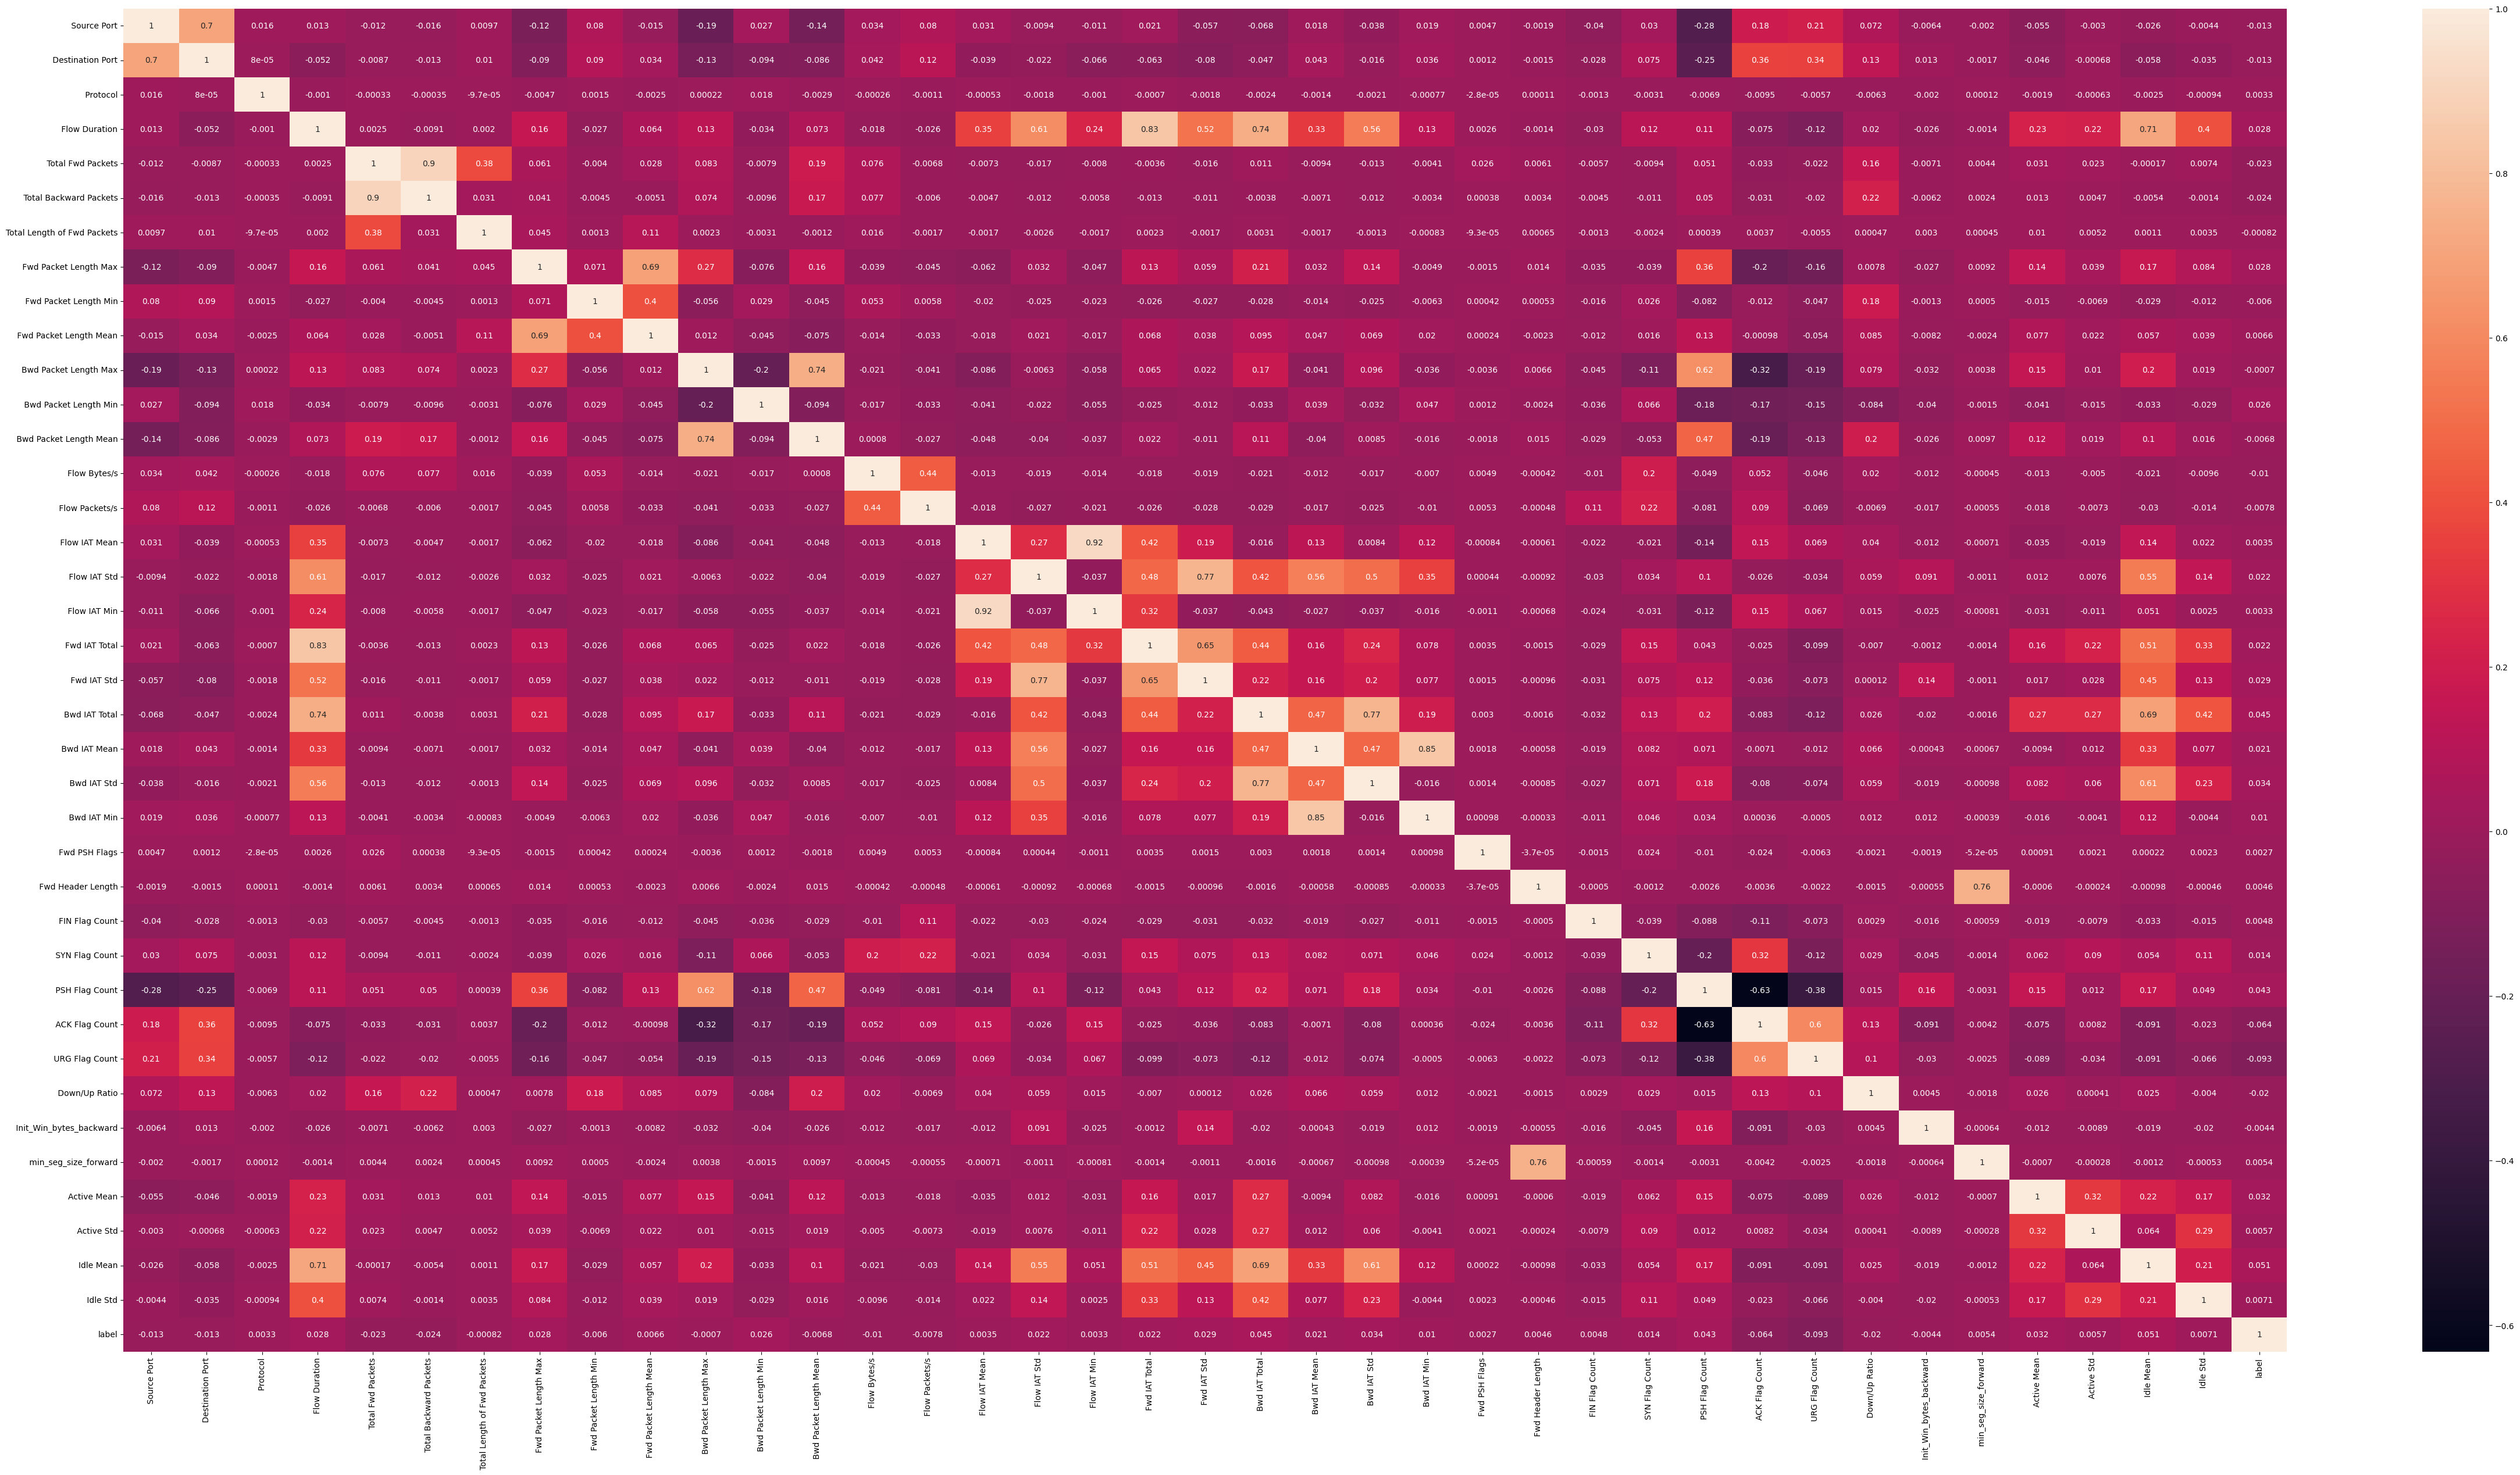

In [ ]:
cor_mat=df_num.corr()
fig = plt.figure(figsize=(60,30))
sns.heatmap(cor_mat,annot=True)

# ***Taking input from user***

In [ ]:
x1 = df1.drop('label', axis=1)
y1 = df1['label']
# Perform feature selection using SelectKBest and f_classif scoring function
selector = SelectKBest(score_func=f_classif, k=15)
X_new = selector.fit_transform(x1, y1)

# Get the indices of the selected features
selected_features_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features_names = x1.columns[selected_features_indices]

# Create a new DataFrame with only the selected features
X_selected = pd.DataFrame(X_new, columns=selected_features_names)

In [ ]:
df1 = X_selected.copy()
df1['label'] = y1
df1.shape
X_selected.shape

(523617, 15)

In [ ]:
df1

,Flow Duration,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Min,Flow IAT Std,Fwd IAT Total,Fwd IAT Std,Bwd IAT Total,Bwd IAT Std,PSH Flag Count,ACK Flag Count,URG Flag Count,Down/Up Ratio,Active Mean,Idle Mean,label
0,12140931.0,208.0,37.111111,0.0,3.179603e+06,12140931.0,4.200924e+06,161697.0,46705.624402,1.0,0.0,0.0,0.0,0.0,0.0,0
1,418882.0,517.0,8.127451,0.0,6.067904e+03,413474.0,1.195078e+04,382119.0,7744.797347,1.0,0.0,0.0,1.0,0.0,0.0,0
2,45.0,55.0,27.500000,0.0,0.000000e+00,45.0,0.000000e+00,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0
3,541699.0,39.0,39.000000,225.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0
4,7310795.0,0.0,0.000000,0.0,5.126208e+06,7310795.0,5.126208e+06,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523612,589453.0,1460.0,584.800000,0.0,1.251750e+05,322092.0,1.609647e+05,325226.0,227351.800714,1.0,0.0,0.0,0.0,0.0,0.0,1
523613,216310.0,37.0,37.000000,74.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0
523614,5215688.0,0.0,0.000000,0.0,0.000000e+00,5215688.0,0.000000e+00,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0
523615,223370.0,1368.0,704.687500,0.0,1.436014e+04,223370.0,2.184051e+04,148694.0,19771.471075,1.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
means = []
stds = []
for i in df1.iloc[:,:-1].columns:
  m = df1[i].mean()

  s = df1[i].std()
  means.append(m)
  stds.append(s)
  df1[i] = abs(df1[i]-m)/s

# z = (x-m)/s

In [ ]:
df1

,Flow Duration,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Min,Flow IAT Std,Fwd IAT Total,Fwd IAT Std,Bwd IAT Total,Bwd IAT Std,PSH Flag Count,ACK Flag Count,URG Flag Count,Down/Up Ratio,Active Mean,Idle Mean,label
0,0.042384,0.021236,0.182887,0.356094,0.112632,0.201272,0.338462,0.300332,0.251400,1.478037,0.941249,0.563199,0.868440,0.18388,0.290557,0
1,0.465692,0.815446,0.417930,0.356094,0.384511,0.381163,0.323516,0.288368,0.258650,1.478037,0.941249,0.563199,0.606238,0.18388,0.290557,0
2,0.483846,0.435515,0.260828,0.356094,0.385462,0.401696,0.325405,0.309109,0.260091,0.676594,1.062451,0.563199,0.868440,0.18388,0.290557,0
3,0.460368,0.478839,0.167569,2.998910,0.385462,0.401698,0.325405,0.309109,0.260091,0.676594,0.941249,0.563199,0.606238,0.18388,0.290557,0
4,0.166971,0.584439,0.483840,0.356094,0.417574,0.038613,0.484683,0.309109,0.260091,0.676594,1.062451,0.563199,0.868440,0.18388,0.290557,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523612,0.458299,3.368814,4.258609,0.356094,0.365853,0.385702,0.299968,0.291456,0.217784,1.478037,0.941249,0.563199,0.868440,0.18388,0.290557,1
523613,0.474472,0.484254,0.183788,0.747329,0.385462,0.401698,0.325405,0.309109,0.260091,0.676594,0.941249,0.563199,0.606238,0.18388,0.290557,0
523614,0.257781,0.584439,0.483840,0.356094,0.385462,0.142665,0.325405,0.309109,0.260091,0.676594,1.062451,0.563199,0.868440,0.18388,0.290557,0
523615,0.474166,3.119705,5.230839,0.356094,0.383212,0.390605,0.321953,0.301038,0.256412,1.478037,0.941249,0.563199,0.868440,0.18388,0.290557,0


In [ ]:
x1 = df1.drop('label', axis=1)
y1 = df1['label']

In [ ]:
rfc1 = RandomForestClassifier()
rfc1.fit(x1, y1)

RandomForestClassifier()

In [ ]:
# To get test data from the user
test_data = input("Enter Test Data :").split(",")
for i in range(0,len(test_data)):
  test_data[i] = float(test_data[i])
for i in range(len(test_data)):
  test_data[i] = abs(test_data[i] - means[i]) / stds[i]
  test_data[i] = float(test_data[i])
v = rfc1.predict([test_data])
print(v)

Enter Test Data :12140931.0,208.0,37.111111,0.0,3.179603e+06,12140931.0,4.200924e+06,161697.0,46705.624402,1.0,0.0,0.0,0.0,0.0,0.0
[0]


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


***INPUTS***
12140931.0,208.0,37.111111,0.0,3.179603e+06,12140931.0,4.200924e+06,161697.0,46705.624402,1.0,0.0,0.0,0.0,0.0,0.0

12140931.0 208.0 37.111111 0.0 3.179603e+06 12140931.0 4.200924e+06 161697.0 46705.624402 1.0 0.0 0.0 0.0 0.0 0.0

> Indented block

589453.0,1460.0,584.800000,0.0,1.251750e+05,322092.0,1.609647e+05,325226.0,227351.800714,1.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
comp_tb = pd.DataFrame({'Model': Models, 'Accuracy': Accuracy, 'Recall': Recall})
print(comp_tb)

           Model  Accuracy    Recall
0            knn  0.971010  0.963711
1  decision tree  0.973588  0.968224
2  random forest  0.973951  0.961559


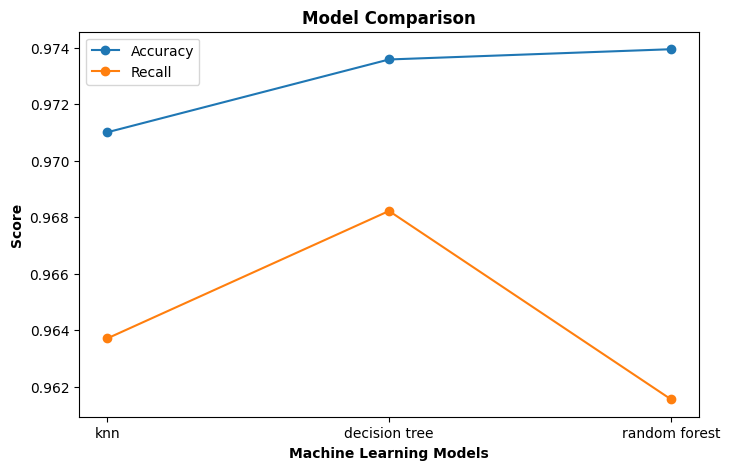

In [ ]:
plt.figure(figsize=(8, 5))

# Plot the accuracy and recall lines for each model
plt.plot(Models, Accuracy, marker='o', label='Accuracy')
plt.plot(Models, Recall, marker='o', label='Recall')

# Add x and y axis labels
plt.xlabel('Machine Learning Models', fontweight='bold')
plt.ylabel('Score', fontweight='bold')

# Set the chart title
plt.title('Model Comparison', fontweight='bold')

# Add a legend and show the plot
plt.legend()
plt.show()

In [ ]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 10.7 MB/s eta 0:

In [ ]:
from joblib import dump
filename = 'model.joblib'
dump(rfc1, filename)
filename = 'm.joblib'
dump(means, filename)
filename = 's.joblib'
dump(stds, filename)

['s.joblib']

In [ ]:
import gradio as gr
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
def predict_category(test_data):
  test = [float(x) for x in test_data.split()]
  for i in range(len(test)):
    test[i] = abs(test[i] - means[i]) / stds[i]
    test[i] = float(test[i])
  v = rfc1.predict([test])
  if(v == 1):
      return "keylogger is detected"
  return "keylogger is not detected"
  # return v
!pip install gradio
import gradio as gr
# input_text = [gr.inputs.Textbox(label='Input')]
input_text= gr.inputs.Textbox(label="Enter 15 inputs")
output_text = gr.outputs.Textbox(label='output')
interface = gr.Interface(fn=predict_category, inputs=input_text, outputs=output_text)

# Launch the interface
interface.launch()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/outputs.py:22: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>